## Import Library

In [1]:
#pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

## Model Selection and Initialization

In [2]:
# List of models optimized for semantic textual similarity can be found at:
# https://docs.google.com/spreadsheets/d/14QplCdTCDwEmTqrn1LH4yrbKvdogK4oQvYO1K1aPR5M/edit#gid=0
#distiluse-base-multilingual-cased-v1
#model = SentenceTransformer('stsb-roberta-large')
#https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [72]:
#library for reading folders and files:
import os
#library for creating dataframes:
import pandas as pd

In [201]:
#set the directory
image_directory = 'data_test/'

In [290]:
#read patients folders names and store them in a list
patient_names = os.listdir(image_directory)

In [291]:
print(patient_names)

['LOUIS', 'PETER', 'VINCENT']


In [292]:
#create 3 empty lists to keep patients data
descriptions = []
photo_names = []
photo_titles = []


#run through the folders and parse the file names. store accordingly into each list. 
for patient_name in patient_names:
    dir_files = os.listdir(image_directory+patient_name)
    temp_list = []
    temp_list_photos = []
    temp_list_titles = []
    for dir_file in dir_files:
        if (dir_file.split('_')[1]=="photo"):
            #print(dir_file)
            if(dir_file.split('_')[3]=="text.txt"):
                #print(dir_file)
                desc = open(image_directory+patient_name+"/"+dir_file, encoding='utf-8').read().rstrip('\n')
                temp_list.append(desc)
            elif(dir_file.split('_')[3]=="image.png"):
                temp_list_photos.append(dir_file)
            elif(dir_file.split('_')[3]=="title.txt"):
                title = open(image_directory+patient_name+"/"+dir_file, encoding='utf-8').read().rstrip('\n')
                temp_list_titles.append(title)                             
                
    descriptions.append(temp_list)
    photo_names.append(temp_list_photos)
    photo_titles.append(temp_list_titles)
            

### Create dataframes to store and get data more easily

In [294]:
#dataframe where images paths are stored:
df_photos = pd.DataFrame(photo_names).transpose()
df_photos.columns = patient_names
df_photos

,LOUIS,PETER,VINCENT
0,LOUIS_photo_10_image.png,PETER_photo_1_image.png,VINCENT_photo_1_image.png
1,LOUIS_photo_1_image.png,PETER_photo_2_image.png,VINCENT_photo_2_image.png
2,LOUIS_photo_2_image.png,PETER_photo_3_image.png,VINCENT_photo_3_image.png
3,LOUIS_photo_3_image.png,PETER_photo_4_image.png,VINCENT_photo_4_image.png
4,LOUIS_photo_4_image.png,PETER_photo_5_image.png,VINCENT_photo_5_image.png
5,LOUIS_photo_5_image.png,None,VINCENT_photo_6_image.png
6,LOUIS_photo_6_image.png,None,VINCENT_photo_7_image.png
7,LOUIS_photo_7_image.png,None,VINCENT_photo_8_image.png
8,LOUIS_photo_8_image.png,None,None
9,LOUIS_photo_9_image.png,None,None


In [295]:
#dataframe where images titles are stored
df_titles = pd.DataFrame(photo_titles).transpose()
df_titles.columns = patient_names
df_titles

,LOUIS,PETER,VINCENT
0,santorin,Bike-trip,bruxelles
1,annecy,Chicago,chat
2,borely,Koyasan,Géant du Nord
3,calanques,Marathon,Gorges du Verdon
4,cerdanya,New York,Haut Doubs
5,draguignan,None,Ile d'Oléron
6,koons,None,Mer du Nord
7,montauban,None,Mölkky
8,lac de payolle,None,None
9,plantes de mon appartement,None,None


In [297]:
#dataframes where images texts are stored
df_texts = pd.DataFrame(descriptions).transpose()
df_texts.columns = patient_names
df_texts

,LOUIS,PETER,VINCENT
0,Voici une photo de la ville principale de Sant...,This is a photo of our summer vacation bicycle...,La viste de la Grand-Place de Bruxelles a perm...
1,C'est une photo du lac d'Annecy pendant l'hive...,This is a photo of my family on vacation in ch...,Cette photo représente mon chat . Elle s’appel...
2,"Voici une photo de la fontaine du parc Borely,...",This is a photo of the sacred Garan area on Mo...,Cette photo a été prise en août 2021 à Bergues...
3,C'est une photo du Parc National des Calanques...,This is a photo of the Austin marathon on spri...,Les gorges du Verdon en juillet 2021 se rempli...
4,Voici une photo de nos vacances d'hiver à vélo...,This is a photo of me and my family on vacatio...,Cette photo a été prise à Arc Sous Cicon dans ...
5,\nC'est une chute d'eau dans le sud-est de la ...,None,L'île d'Oléron est déserte en dehors de la pér...
6,C'est une photo de l'exposition Koons au musée...,None,"Lors d’un séjour en Belgique, en août 2021, j’..."
7,"\nC'est une photo de ma ville natale, où j'ai ...",None,A l’issue d’un repas familial au printemps 202...
8,C'est une photo du sentier autour du lac de Pa...,None,None
9,Voici une photo des plantes que je cultive à l...,None,None


### similarity matrix between patient_1 and patient_2

In [284]:
patient_1 = "PETER"
patient_2 = "VINCENT"

In [299]:
#create empty arrays for text embeddings and similarity matrix
embeddings_patient_1 = np.empty([df_texts[patient_1].dropna().size,512])
embeddings_patient_2 = np.empty([df_texts[patient_2].dropna().size,512])
sim_matrix = np.empty([10,10])

In [300]:
#calculate the embeddings values for both patients columns
for i in range(df_texts[patient_1].dropna().size):
    sentence_embedding = model.encode(df_texts[patient_1].dropna().iloc[i], convert_to_tensor=True)
    embeddings_patient_1[i] = sentence_embedding

for i in range(df_texts[patient_2].dropna().size):
    sentence_embedding = model.encode(df_texts[patient_2].dropna().iloc[i], convert_to_tensor=True)
    embeddings_patient_2[i] = sentence_embedding

In [303]:
#calculate the cosine similarity between the two embeddings
for i in range(len(embeddings_patient_1)):
    for j in range(len(embeddings_patient_2)):
        sim_matrix[i,j]=cosine_similarity([embeddings_patient_1[i],embeddings_patient_2[j]])[0,1]
    

<function matplotlib.pyplot.show(close=None, block=None)>

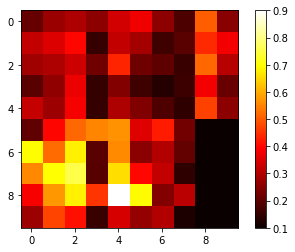

In [304]:
#plot the similarity matrix
plt.imshow(sim_matrix,cmap="hot")
plt.colorbar()
plt.show

### get the highest similarity

In [305]:
# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embeddings_patient_1, embeddings_patient_2)

#compare each text of patient_1 with each text of patient_2 then print the most similar
for i in range(len(embeddings_patient_1)):
    for j in range(len(embeddings_patient_2)):
        if(cosine_scores[i][j].item() == cosine_scores.max().item()):
            print("Description", patient_1, ":", df[patient_1].dropna().iloc[i])
            print("Description", patient_2, ":", df[patient_2].dropna().iloc[j])
            print("Similarity Score:", cosine_scores[i][j].item())
            #get the index of the two most sililar photos. Each dataframe normally has the same index.
            index_1 = i
            index_2 = j
            
print(index_1)
print(index_2)

#get the corresponding values for each index in the two other dataframes
photo_file1 = df_photos[patient_1].dropna().iloc[index_1]
photo_title1 = df_titles[patient_1].dropna().iloc[index_1]

photo_file2 = df_photos[patient_2].dropna().iloc[index_2]
photo_title2 = df_titles[patient_2].dropna().iloc[index_2]

#print the values 
print(photo_file1)
print(photo_title1)
print(photo_file2)
print(photo_title2)





Description PETER : This is a photo of the sacred Garan area on Mount Koyasan in Japan.
I took this photo in the Garan area on Mount Koyasan one year ago, in January 2019. I was by myself, but there was the spirit of Kobo-Daishi Kukai. Koyasan is a sacred mountain with a 20km pilgrimage trail, and temples where pilgrims can stay. I enjoy Koyasan and this picture reminds me of it.
Description VINCENT : Cette photo a été prise à Arc Sous Cicon dans le Haut Doubs durant l'hiver 2022.La neige était au rendez-vous pour la pratique du ski de fond en famille. Les adeptes du skating cohabitent sur les pistes avec les accros du ski de fond alternatif. Du haut de ses 1150 mètres, le Crêt Monniot permet de découvrir au loin les contreforts des Alpes suisses sous un soleil généreux. Les températures négatives nocturnes ont permis de préserver le manteau neigeux jusque début mars alors que les premiers bourgeons aux arbres annoncent déjà l'arrivée du printemps.
Similarity Score: 0.43735615661224514

### previous version

In [94]:
embeddings = np.empty([10,512])
sim_matrix = np.empty([10,10])

get the embeddings

In [6]:
for i in range(len(list_of_paragraphs)):
    #print(list_of_paragraphs[i])
    sentence_embedding = model.encode(list_of_paragraphs[i], convert_to_tensor=True)
    embeddings[i] = sentence_embedding
    

calculate the similarity

In [7]:
for i in range(len(list_of_paragraphs)):
    for j in range(len(list_of_paragraphs)):
        sim_matrix[i,j]=cosine_similarity([embeddings[i],embeddings[j]])[0,1]
    

plot the similarity

<function matplotlib.pyplot.show(close=None, block=None)>

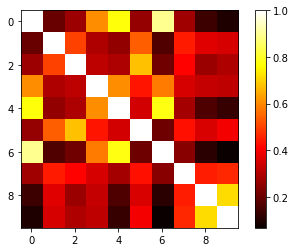

In [8]:
plt.imshow(sim_matrix,cmap="hot")
plt.colorbar()
plt.show

* find trajectory in matrix to visit different similar photo pairs
* present sequence in a coheret interaction scenario
* use french language

## Calculate semantic similarity between two sentences

In [288]:
sentence1 = "Jag tycker om att äta pannkakor. Vi gick lite i skogen när vi var på semester."
sentence2 = "J'adore manger des chips et nager dans la mer. J'ai hâte d'être en vacances et de faire des promenades."

# encode sentences to get their embeddings
embedding1 = model.encode(sentence1, convert_to_tensor=True)
embedding2 = model.encode(sentence2, convert_to_tensor=True)

# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)

print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

Sentence 1: Jag tycker om att äta pannkakor. Vi gick lite i skogen när vi var på semester.
Sentence 2: J'adore manger des chips et nager dans la mer. J'ai hâte d'être en vacances et de faire des promenades.
Similarity score: 0.11038986593484879


## Calculate semantic similarity between two lists of sentences

In [10]:
sentences1 = ["I like Python because I can build AI applications", "The cat sits on the ground","I always wanted to go to Japan, but I never had a chance.  Finally I went to Kyoto"]   
sentences2 = ["I like Python because I can do data analytics", "The cat walks on the sidewalk","This is a picture of a favorite place on Mount Koya, near Kobe"]

# encode list of sentences to get their embeddings
embedding1 = model.encode(sentences1, convert_to_tensor=True)
embedding2 = model.encode(sentences2, convert_to_tensor=True)

# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)

for i in range(len(sentences1)):
    for j in range(len(sentences2)):
        print("Sentence 1:", sentences1[i])
        print("Sentence 2:", sentences2[j])
        print("Similarity Score:", cosine_scores[i][j].item())
        print()

Sentence 1: I like Python because I can build AI applications
Sentence 2: I like Python because I can do data analytics
Similarity Score: 0.6948120594024658

Sentence 1: I like Python because I can build AI applications
Sentence 2: The cat walks on the sidewalk
Similarity Score: 0.019101187586784363

Sentence 1: I like Python because I can build AI applications
Sentence 2: This is a picture of a favorite place on Mount Koya, near Kobe
Similarity Score: 0.03388865664601326

Sentence 1: The cat sits on the ground
Sentence 2: I like Python because I can do data analytics
Similarity Score: 0.021911125630140305

Sentence 1: The cat sits on the ground
Sentence 2: The cat walks on the sidewalk
Similarity Score: 0.5934418439865112

Sentence 1: The cat sits on the ground
Sentence 2: This is a picture of a favorite place on Mount Koya, near Kobe
Similarity Score: 0.09048697352409363

Sentence 1: I always wanted to go to Japan, but I never had a chance.  Finally I went to Kyoto
Sentence 2: I like

## Retrieve Top K most similar sentences from a corpus given a sentence

In [134]:
corpus = ["I like Python because I can build AI applications",
          "I like Python because I can do data analytics",
          "The cat sits on the ground",
         "The cat walks on the sidewalk",
         "I always wanted to go to Japan, but I never had a chance.  Finally I went to Kyoto",
         "This is a picture of a favorite place on Mount Koya, near Kobe"]

# encode corpus to get corpus embeddings
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

In [135]:
sentence = "Saicho went to Mount Hiei near Kyoto"

# encode sentence to get sentence embeddings
sentence_embedding = model.encode(sentence, convert_to_tensor=True)

In [136]:
sentence_embedding.shape

torch.Size([512])

In [137]:
# top_k results to return
top_k=2

# compute similarity scores of the sentence with the corpus
cos_scores = util.pytorch_cos_sim(sentence_embedding, corpus_embeddings)[0]

# Sort the results in decreasing order and get the first top_k
top_results = np.argpartition(-cos_scores, range(top_k))[0:top_k]

print("Sentence:", sentence, "\n")
print("Top", top_k, "most similar sentences in corpus:")
for idx in top_results[0:top_k]:
    print(corpus[idx], "(Score: %.4f)" % (cos_scores[idx]))

Sentence: Saicho went to Mount Hiei near Kyoto 

Top 2 most similar sentences in corpus:
I always wanted to go to Japan, but I never had a chance.  Finally I went to Kyoto (Score: 0.4942)
This is a picture of a favorite place on Mount Koya, near Kobe (Score: 0.4589)
